In [1]:
import pandas as pd
ratings = pd.read_csv("datasets/ratings.csv")
ratings.head()

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264


In [2]:
movies = pd.read_csv("datasets/movies.csv")
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
#Extrair o ano
movies["year"] = movies.title.str.extract("\((\d{4})\)")
movies.title = movies.title.str[:-7]
movies.head()

,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


In [4]:
#Explode the genre (para o plot)
movies_genre_plot_data = pd.DataFrame(movies)
movies_genre_plot_data["genre"] = pd.DataFrame(movies_genre_plot_data.genres.str.split("|", expand = False).values)
movies_genre_plot_data = movies_genre_plot_data.explode("genre")
movies_genre_plot_data = movies_genre_plot_data.drop(columns = "genres")
movies_genre_plot_data.head(10)

,movieId,title,year,genre
0,1,Toy Story,1995,Adventure
0,1,Toy Story,1995,Animation
0,1,Toy Story,1995,Children
0,1,Toy Story,1995,Comedy
0,1,Toy Story,1995,Fantasy
1,2,Jumanji,1995,Adventure
1,2,Jumanji,1995,Children
1,2,Jumanji,1995,Fantasy
2,3,Grumpier Old Men,1995,Comedy
2,3,Grumpier Old Men,1995,Romance


In [5]:
tags = pd.read_csv("datasets/tags.csv")
tags.head()

,userId,movieId,tag,timestamp
0,14,110,epic,1443148538
1,14,110,Medieval,1443148532
2,14,260,sci-fi,1442169410
3,14,260,space action,1442169421
4,14,318,imdb top 250,1442615195


In [6]:
links = pd.read_csv("datasets/links.csv")
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [7]:
genome_tags = pd.read_csv("datasets/genome-tags.csv")
print(genome_tags.head())
print(genome_tags.shape)

   tagId           tag
0      1           007
1      2  007 (series)
2      3  18th century
3      4         1920s
4      5         1930s
(1128, 2)


In [8]:
genome_scores = pd.read_csv("datasets/genome-scores.csv")
print(genome_scores.shape)
genome_scores.head()

(14862528, 3)


,movieId,tagId,relevance
0,1,1,0.02900
1,1,2,0.02375
2,1,3,0.05425
3,1,4,0.06875
4,1,5,0.16000


# Informação sobre os dados:

* Os dataframes "movies", "tags", "ratings" e "genome_scores" estão todos ligados pelo atributo movieId
* Há 1128 tags diferentes e estão todas identificadas por um id em "genome_tags"
* Todos os filmes possuem um indicador do quão relevante é uma tag para o mesmo em "genome_scores"
* Pode haver inconsistências nos anos dos filmes que aparecem ao lado do titulo em "movies"

# Pré-processamento:

* Retirar o ano do filme da coluna "title" e colocá-lo numa coluna à parte (feito)
* Usar MultiLabelBinarizer para transformar os valores categoricos da coluna "genres" em valores numéricos
* Transformar timestamps de unix time para data
* O ficheiro dos links não tem informação util para este trabalho
* Fazer um cut aleatório nos "movies" para reduzir o tamanho da população para 10M

# EDA:

* Quantos filmes há de cada género?
* Como é que o rating médio dos filmes evolui ao longo dos anos?
* Quais as tags com mais relevância de cada filme?
* Rating médio de filmes conforme género

**Esta visualização deve ser feita para o dataset sampled que é utilizado na produção do sistema de recomendação (Neste momento está a ser feita para o dataset completo)**

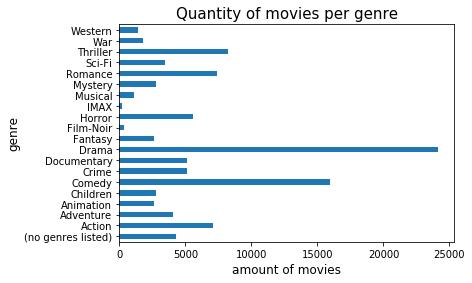

In [9]:
#Quantos filmes há de cada género:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline

data = movies_genre_plot_data.groupby("genre")["title"].count().plot.barh()
plt.xlabel("amount of movies", size = 12);
plt.ylabel("genre", size = 12);
plt.title("Quantity of movies per genre", size = 15);

#Este gráfico pode ser mostrado numa wordcloud (fazer experiencia, pode ser interessante)

#### Crescimento anual de filmes de certos géneros:
* Ver para os 5 géneros mais relevantes (presentes em mais filmes)

In [10]:
#Rating médio por ano
ratings_plot = pd.DataFrame(ratings)
ratings_plot["date"] = pd.to_datetime(ratings_plot.timestamp, unit = "s")
ratings_plot.index = pd.DatetimeIndex(ratings_plot.date)

ratings_plot["year"] = pd.DatetimeIndex(ratings_plot["date"]).year
ratings_plot["month"] = pd.DatetimeIndex(ratings_plot["date"]).month

ratings_plot = ratings_plot.drop(columns = ["timestamp", "date", "movieId", "userId"])

ratings_plot.head()

,rating,year,month
date,,,
2009-10-27 21:00:21,3.5,2009,10
2009-10-27 21:04:16,3.5,2009,10
2009-10-27 21:04:31,1.5,2009,10
2009-10-27 21:04:20,4.5,2009,10
2009-10-27 21:01:04,4.5,2009,10


#### Rating médio ao longo dos anos:
há uma oscilação muito pequena no rating médio ao longo dos anos

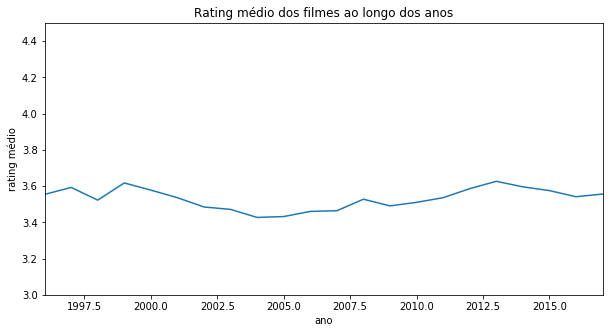

In [11]:
#Line plot
matplotlib.rcParams["figure.figsize"] = [10, 5]
ratings_line_plot = ratings_plot.groupby("year")["rating"].apply(lambda x: x.mean()).reset_index()
ratings_line_plot = ratings_line_plot.drop(ratings_line_plot[(ratings_line_plot.year == 1995) | (ratings_line_plot.year == 2018)].index)

ratings_line_plot.plot(x = "year", y = "rating", legend = False);
plt.ylim(3,4.5);
plt.ylabel("rating médio");
plt.xlabel("ano")
plt.title("Rating médio dos filmes ao longo dos anos");

In [12]:
monthly_ratings = ratings_plot.drop(ratings_plot[(ratings_plot.year == 1995) | (ratings_plot.year == 2018)].index)
monthly_ratings = monthly_ratings.drop(columns = ["year", "month"])
monthly_ratings = monthly_ratings["rating"].resample(rule = "M").mean()
monthly_ratings = monthly_ratings.dropna()
monthly_ratings

date
1996-01-31    3.984848
1996-02-29    3.739796
1996-03-31    3.943338
1996-04-30    3.805410
1996-05-31    3.508180
                ...   
2017-08-31    3.598258
2017-09-30    3.504358
2017-10-31    3.572797
2017-11-30    3.531924
2017-12-31    3.522993
Name: rating, Length: 263, dtype: float64

#### Evolução mensal do rating médio dos filmes:
* É possivel ver certos periodos em que o rating melhora um pouco
* Em geral este grafico ta uma jorda e nao mostra nada de interessante que eu pensei que ia mostrar (tipo sazonalidade) :(

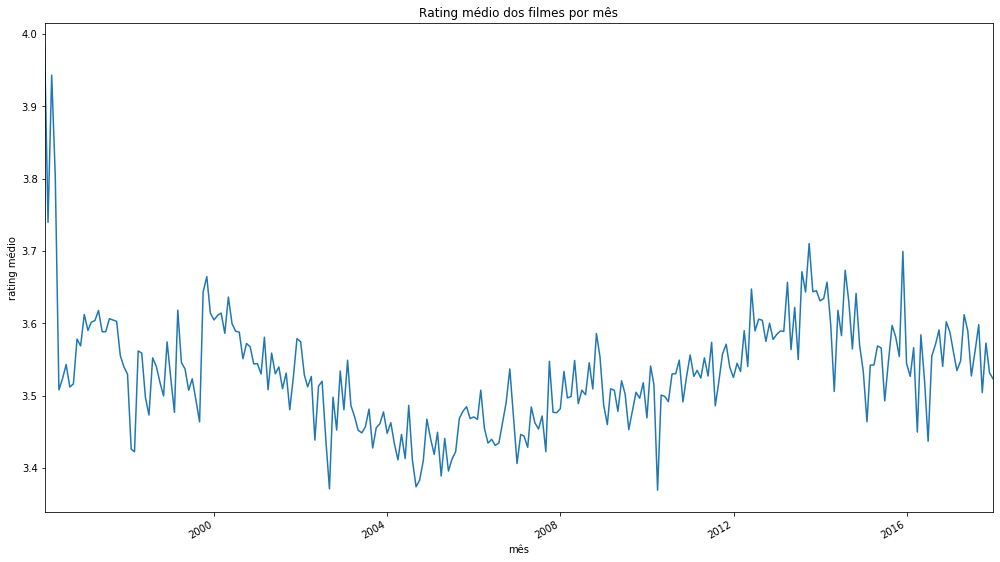

In [13]:
#Line plot oscilação mensal
matplotlib.rcParams["figure.figsize"] = [17, 10]
monthly_ratings.plot(x = monthly_ratings.index, y = "rating", legend = False)
plt.ylabel("rating médio")
plt.xlabel("mês")
plt.title("Rating médio dos filmes por mês");

In [14]:
monthly_scatter = ratings_plot.drop(ratings_plot[(ratings_plot.year == 1995) | (ratings_plot.year == 2018)].index)
monthly_scatter = monthly_scatter.groupby(["year", "month"])["rating"].apply(lambda x: x.mean()).reset_index()
monthly_scatter = monthly_scatter.dropna()
monthly_scatter.head()

,year,month,rating
0,1996,1,3.984848
1,1996,2,3.739796
2,1996,3,3.943338
3,1996,4,3.805410
4,1996,5,3.508180


#### Scatter plot ratings médios por mês:
* Substituto do boxplot (será melhor boxplot? provavelmente)
* mostra a distribuição do rating médio pelos meses do ano no intervalo 1996-2017
* Certos meses apresentam outliers (certa tendencia para votar melhor nos primeiros meses do ano?)
* Faltou traduzir os meses de valor numerico para categorico

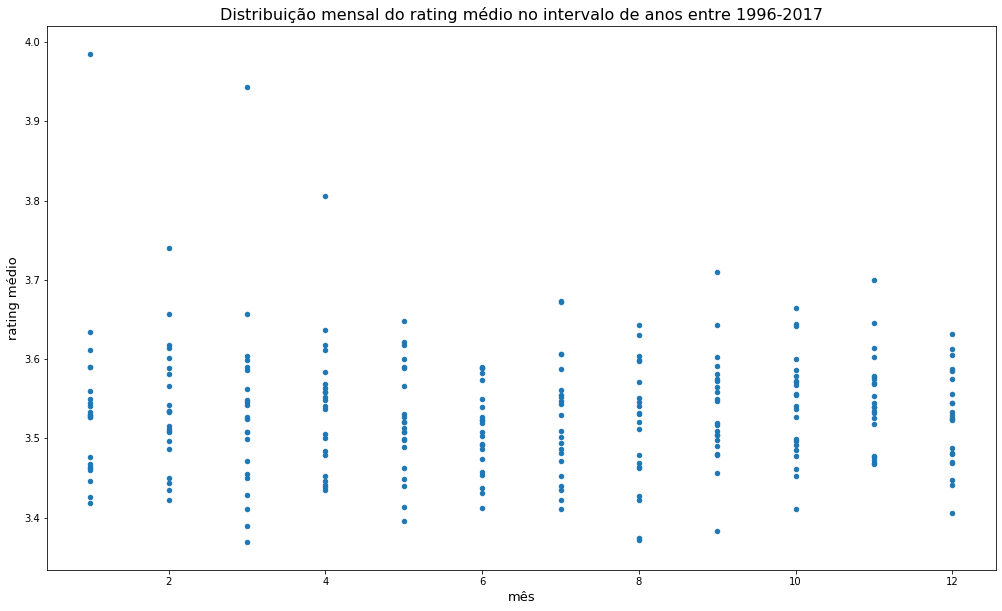

In [15]:
monthly_scatter.plot.scatter(x = "month", y = "rating", legend = False)
plt.title("Distribuição mensal do rating médio no intervalo de anos entre 1996-2017", size = 16)
plt.ylabel("rating médio", size = 13)
plt.xlabel("mês", size = 13);

#### Boxplot dos ratings por ano
Neste gráfico da para ver a distribuição dos ratings por ano (tentei fazer com um scatter mas nao consegui).

Percebe-se também os outliers que existem em cada ano, nomeadamente quando o rating esta perto de 1

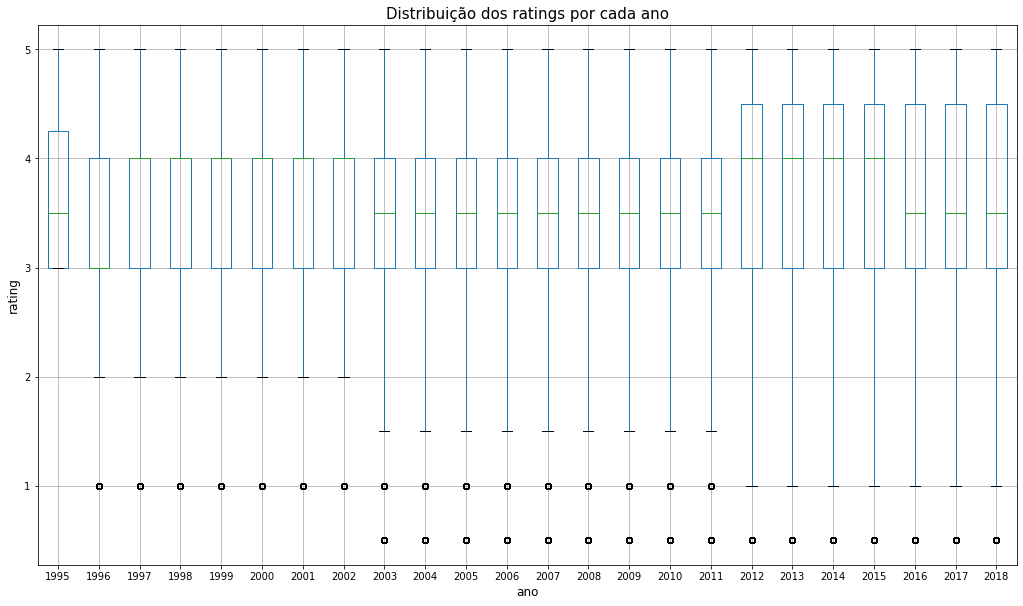

In [16]:
matplotlib.rcParams["figure.figsize"] = [17, 10]
ratings_plot.boxplot(by = "year", column = "rating")
plt.title("Distribuição dos ratings por cada ano", size = 15)
plt.suptitle("")
plt.ylabel("rating", size = 12)
plt.xlabel("ano", size = 12);

In [17]:
#id do valor maximo da relevancia por movieId
most_relevant = genome_scores.loc[genome_scores.groupby("movieId")["relevance"].idxmax()]
print(most_relevant.shape)

most_relevant = most_relevant.join(genome_tags.set_index("tagId"), on = "tagId")
most_relevant = most_relevant.groupby("tag")["tagId"].apply(lambda x: x.size).reset_index()
most_relevant = most_relevant.nlargest(20, ["tagId"])
most_relevant.head()

(13176, 3)


,tag,tagId
161,comedy,310
184,criterion,282
370,horror,248
73,based on a book,194
627,romantic comedy,161


#### Quantidades de tags mais relevantes:
* Quantidade vezes que uma tag é a mais relevant por filme cada filme
* Interpretação: Há cerca de 300 filmes em que a tag mais relevante é comédia
* Percebe-se quais são as tendencias no que toca a filmes produzidos

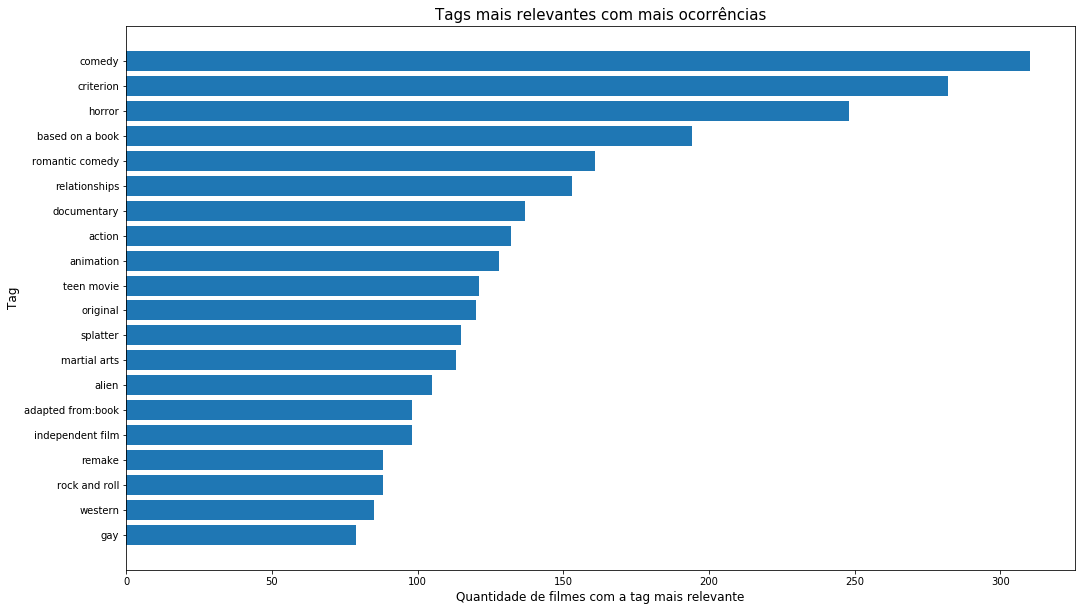

In [18]:
#Show most relevant tags graph
import numpy as np
y = np.arange(len(most_relevant.tag))
x = most_relevant.tagId

fig, ax = plt.subplots()
ax.barh(y, x)
ax.set_yticks(y)
ax.set_yticklabels(most_relevant.tag)
ax.invert_yaxis()
ax.set_title("Tags mais relevantes com mais ocorrências", size = 15)
ax.set_xlabel("Quantidade de filmes com a tag mais relevante", size = 12)
ax.set_ylabel("Tag", size = 12)
plt.show()

In [19]:
#procurar as tags mais relevantes de cada filme
tags_per_year = genome_scores.loc[genome_scores.groupby("movieId")["relevance"].idxmax()]

#juntar o ano do filme
tags_per_year = tags_per_year.join(movies.set_index("movieId"), on = "movieId")
tags_per_year = tags_per_year.drop(columns = ["title", "genres", "genre", "movieId"])

#juntar o nome da tag
tags_per_year = tags_per_year.join(genome_tags.set_index("tagId"), on = "tagId")

#Contagem da quantidade de cada tag
tags_per_year = tags_per_year.groupby(["year","tag"])["tagId"].apply(lambda x: x.size).reset_index()

#as_index = False, permitiu fazer o groupby e manter as colunas nao indicadas no mesmo
#tag mais relevante com mais quantidade (x.max) por ano (groupby year)
tags_per_year = tags_per_year.groupby("year", as_index = False).apply(lambda x: x.max()).reset_index()
tags_per_year = tags_per_year.drop(columns = "index")

#apenas se mostra filmes de 1995 para a frente, anos anteriores tem dados erráticos
tags_per_year = tags_per_year[tags_per_year.year >= "1995"]
tags_per_year.head()

,year,tag,tagId
83,1995,wwii,8
84,1996,women,7
85,1997,writer's life,15
86,1998,writer's life,11
87,1999,workplace,9


#### Evolução temporal das tags:
* Tags mais relevantes de cada ano
* Apenas entre 1995-2018
* tagId = quantidade de filmes com aquela tag

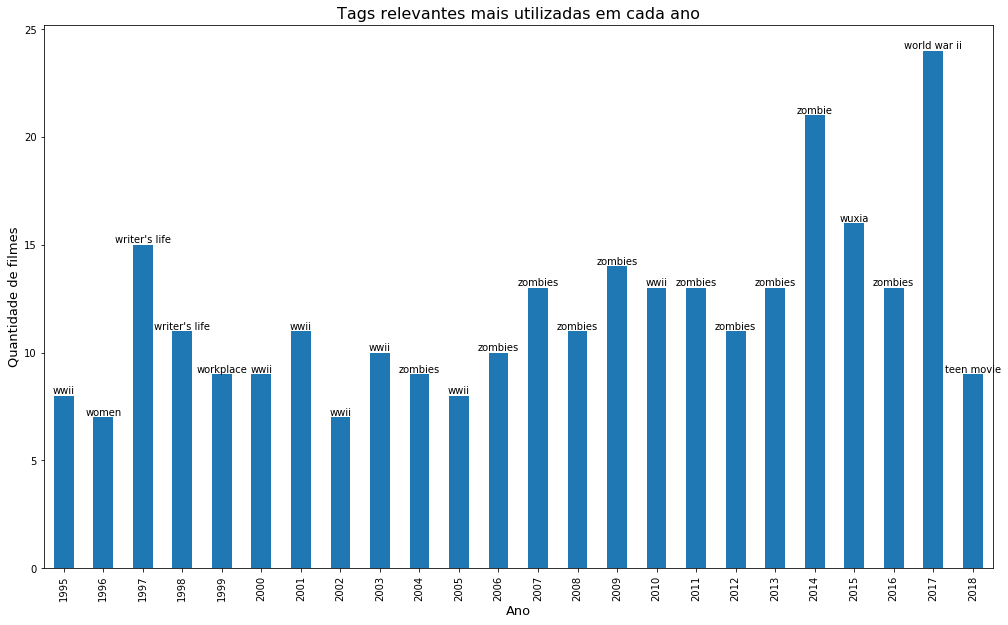

In [20]:
#histograma
ax = tags_per_year.tagId.plot(kind = "bar")
ax.set_title("Tags relevantes mais utilizadas em cada ano", size = 16)
ax.set_xlabel("Ano", size = 13)
ax.set_ylabel("Quantidade de filmes", size = 13)
ax.set_xticklabels(tags_per_year.year)

rects = ax.patches

for rect, label in zip(rects, tags_per_year.tag):
    ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height(), label, ha='center', va='bottom')

In [21]:
genre_ratings = ratings.drop(columns = ["userId", "timestamp", "date", "year", "month"]).reset_index()
genre_ratings = genre_ratings.drop(columns = "date")

genre_ratings = movies_genre_plot_data.join(genre_ratings.set_index("movieId"), on = "movieId")
genre_ratings = genre_ratings.groupby("genre")["rating"].apply(lambda x: x.mean()).reset_index()
genre_ratings.head()

MemoryError: 

#### Variação do rating médio por género de filme:
* Existe alguma variação notável entre os diferentes géneros
* Filmes de terror (ficções) são mal classificados em geral
* Filmes mais sérios, como documentários, filmes noir (mais clássicos) ou filmes de guerra, são em geral mais bem classificados
* Existe alguma parcialidade nos ratings relacionada com o género (em escala pequena)

In [ ]:
import numpy as np
y = np.arange(len(genre_ratings.genre))
x = genre_ratings.rating

fig, ax = plt.subplots()
ax.barh(y, x)
ax.set_yticks(y)
ax.set_yticklabels(genre_ratings.genre)
ax.invert_yaxis()
ax.set_title("Rating médio por género de filme", size = 16)
ax.set_xlabel("Rating médio", size = 13)
ax.set_ylabel("Genre", size = 13)
ax.set_xlim(3,4)
plt.show()

#### Quais as tags que explicam um certo género:
* Tags mais relevantes de um certo género
* Verificar todos os filmes desse género
* Quantidade das cinco tags mais relevantes que aparecem nos filmes de drama (por exemplo)

### Links:
[MultiLabelBinarizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html)

[Como por em pratica](https://stackoverflow.com/questions/52189126/how-to-elegantly-one-hot-encode-a-series-of-lists-in-pandas)

[Paper](https://www.researchgate.net/profile/Susan_Gauch/publication/261199217_Personalized_News_Recommendation_Using_Twitter/links/5676d61a08aebcdda0e95590.pdf) sobre sistema hibrido de recomendação baseado em popularity e no perfil do utilizador (com avaliação do algoritmo)

# Conclusões:

## Modelos a avaliar

* Popularity based
* Collaborative filter
    * User based
    * Item based
* Memory based

- Ensemble de dois modelos:
    * Popularity + User based